In [1]:
# This is only needed if the notebook is run in VSCode
from IPython.display import clear_output, DisplayHandle
def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)
DisplayHandle.update = update_patch

In [2]:
import sys
sys.path.append('..')
import sklearn
from tsai.basics import *
from swdf.utils import *
my_setup(sklearn)
from matplotlib import dates as mdates
import wandb
from fastai.callback.wandb import WandbCallback
from fastai.callback.progress import ShowGraphCallback
from itertools import chain

os              : Linux-6.8.0-39-generic-x86_64-with-glibc2.31
python          : 3.10.12
tsai            : 0.3.10
fastai          : 2.7.15
fastcore        : 1.5.49
sklearn         : 1.5.1
torch           : 2.2.2+cu121
device          : 1 gpu (['NVIDIA GeForce RTX 3070 Ti Laptop GPU'])
cpu cores       : 14
threads per cpu : 1
RAM             : 15.28 GB
GPU memory      : [8.0] GB


In [3]:
# This is only needed for the MIT supercloud, to fix fastai's LRFinder error 
if torch.cuda.is_available() and torch.cuda.device_count() == 0:
    from fastai.callback.schedule import LRFinder

    @patch_to(LRFinder)
    def after_fit(self):
        self.learn.opt.zero_grad() # Needed before detaching the optimizer for future fits
        tmp_f = self.path/self.model_dir/self.tmp_p/'_tmp.pth'
        if tmp_f.exists():
            self.learn.load(f'{self.tmp_p}/_tmp', with_opt=True, device='cpu')
            self.tmp_d.cleanup()

# Forecasting solar drivers F10, S10, M10 and Y10

Some hints about hyperparameters:
- According to the authors of PatchTST: "The ideal patch length may depend on the dataset, 
but P between {8, 16} seems to be general good numbers."

In [4]:
config_base = yaml2dict('./config/base.yaml', attrdict=True)
config_solfsmy = yaml2dict('./config/solfsmy.yaml', attrdict=True)
config_solfsmy = config_solfsmy.train
# Merge the two configs (the second one overrides the first one for any keys that are present in both)
config = AttrDict({**config_base, **config_solfsmy})
# Add the architecture config
if config.arch_name.lower() == 'patchtst':
    config.arch = yaml2dict('./config/patchtst.yaml', attrdict=True)
else:
    config.arch = AttrDict()

In [5]:
run = wandb.init(project=config.wandb.project, 
                 config=config,
                 group=config.wandb.group,
                 mode=config.wandb.mode, 
                 anonymous='never') if config.wandb.enabled else None
config = dict2attrdict(run.config) if config.wandb.enabled else config

In [6]:
config

```json
{ 'add_time_channels': False,
  'arch': { 'decomposition': True,
            'individual': True,
            'padding_patch': True,
            'revin': True},
  'arch_config_file': 'config/patchtst.yaml',
  'arch_name': 'PatchTST',
  'bs': 32,
  'data_columns_fcst': ['F10', 'S10', 'M10', 'Y10'],
  'data_path': '../data/SOLFSMY.TXT',
  'data_url': 'https://sol.spacenvironment.net/JB2008/indices/SOLFSMY.TXT',
  'deltaHL': 2.0,
  'horizon': 6,
  'init_weights': False,
  'is_optuna_study': False,
  'lookback': 36,
  'lr_max': None,
  'n_epoch': 30,
  'partial_n': 0.1,
  'seed': 42,
  'test_end_datetime': '2018-12-31 12:00:00',
  'test_start_datetime': '2012-10-01 12:00:00',
  'valid_start_datetime': '2018-01-01 12:00:00',
  'wandb': { 'enabled': False,
             'group': None,
             'log_learner': True,
             'mode': 'offline',
             'project': 'swdf'}}
```

In [7]:
fname = config.data_path if config.data_url is None else download_data(config.data_url,
                                                                       fname=config.data_path) # Add 'force_download=True' to always update the data
fname

Path('../data/SOLFSMY.TXT')

In [8]:
# Read the text file into a pandas DataFrame, ignoring the lines starting with '#'
# Column names: YYYY DDD   JulianDay  F10   F81c  S10   S81c  M10   M81c  Y10   Y81c  Ssrc
df_raw = pd.read_csv(fname, delim_whitespace=True, comment='#', header=None, 
                 names=['Year', 'DDD', 'JulianDay', 'F10', 'F81c', 'S10', 'S81c', 
                        'M10', 'M81c', 'Y10', 'Y81c', 'Ssrc'])
df_raw.head()

,Year,DDD,JulianDay,F10,F81c,S10,S81c,M10,M81c,Y10,Y81c,Ssrc
0,1997,1,2450450.0,72.4,78.0,74.0,79.2,65.4,73.8,61.9,70.7,1B11
1,1997,2,2450451.0,72.1,77.9,73.8,79.1,66.9,73.7,63.4,70.4,1B11
2,1997,3,2450452.0,73.3,77.6,75.0,79.1,70.1,73.6,64.9,70.2,1B11
3,1997,4,2450453.0,73.8,77.3,76.3,79.0,71.6,73.4,65.5,69.8,1B11
4,1997,5,2450454.0,74.4,76.9,77.6,78.9,72.4,73.3,66.7,69.6,1B11


F10, S10, M10, and Y10 (81c) have different observation and report times; to standardize reporting, all values are reported in sfu units at 12UT (Universal Time); observations are 3-times daily for F10 (20 UT used), every 5 minutes for S10 (daily average used), twice daily for M10 (7 and 16 UT), and every 1 minute for Y10 (Xrays are each minute while Lya is daily); 

For model inputs the values should be used as a daily value between 0-24 UT for a given calendar date; F10 and S10 are 1-day lagged, M10 is 2-day, and Y10 is 5-day lagged in JB2008; the 81-day centered values are used with the same respective lag times. Ssrc has 4 fields (1 for each index): 

*  0 = (F10, S10, M10, Y10) spline-filled if value or missing if no value; 
* 1 = (F10, M10, Y10) derived or measured index, (S10) SOHO/SEM; 
* 2 = (S10) TIMED/SEE v11; 
* 3 = (S10) SOHO gap (daily); 
* 4 = (S10) SOHO gap (average); 
* 5 = (F10) F10 mean (2 surrounding values), (S10) SDO/EVE; 
* 6 = (S10) GOES/EUVS fill-in, (M10) M10 mean (2 surrounding values); 
* 7 = (S10) S10 scaled to match M10 change from previous day; 
* 8 = (S10) SDO/EVE corrections and all S10 tweaked from sat 12388 delta B%, (Y10) UARS/SOLSTICE V18; 
* 9 = (S10) replace original v4.0h data for versions 4.0 and higher, (Y10) UARS/SOLSTICE v19; 
* A = (S10) TIMED/SEE solar minimum correction; 
* B = (S10) replace with original v4.0h S10 data for versions 4.0 and higher, (M10) SORCE/SOLSTICE/SIM v9; 
* C = (S10) SDO/EVE correction, (Y10) GOES XRS; 
* D = (S10) validated TIMED/SEE, (Y10) GOES XRS and SET composite LYA; 
* E = (S10) S10 composite, (Y10) SET composite LYA; 
* F = (F10, S10, M10, Y10) mean of bordering values

Acronyms:
* SOHO/SEM: Solar and Heliospheric Observatory/ Spacecraft's Solar Extreme-ultraviolet Monitor (SEM)
* SDO/EVE: Solar Dynamics Observatory/Extreme Ultraviolet Variability Experiment.
* UARS/SOLSTICE: Upper Atmosphere Research Satellite/Solar Stellar Irradiance Comparison Experiment
* SORCE/SOLSTICE/SIM: Solar Radiation and Climate Experiment/SOLSTICE/Spectral Irradiance Monitor
* GOES/XRS: Geostationary Operational Environmental Satellite/X-Ray Sensor
* "SET composite LYA" refers to the solar irradiance in the Lyman-alpha (Lyα) wavelength range, as measured by the Solar EUV Experiment Telescope (SET) onboard the Solar Radiation and Climate Experiment (SORCE) spacecraft.

This webpage contains forecasts (paid forecast) that we can use to compare to
https://agupubs.onlinelibrary.wiley.com/doi/pdf/10.1029/2020SW002496. It's interesting
to see what they forecast from the previous data in order to try the same thing 
with the neural network

In [9]:
legend_mapping = {
    '0': '(F10, S10, M10, Y10) spline-filled if value or missing if no value',
    '1': '(F10, M10, Y10) derived or measured index, (S10) SOHO/SEM',
    '2': '(S10) TIMED/SEE v11',
    '3': '(S10) SOHO gap (daily)',
    '4': '(S10) SOHO gap (average)',
    '5': '(F10) F10 mean (2 surrounding values), (S10) SDO/EVE',
    '6': '(S10) GOES/EUVS fill-in, (M10) M10 mean (2 surrounding values)',
    '7': '(S10) S10 scaled to match M10 change from previous day',
    '8': '(S10) SDO/EVE corrections and all S10 tweaked from sat 12388 delta B%, (Y10) UARS/SOLSTICE V18',
    '9': '(S10) replace original v4.0h data for versions 4.0 and higher, (Y10) UARS/SOLSTICE v19',
    'A': '(S10) TIMED/SEE solar minimum correction',
    'B': '(S10) replace with original v4.0h S10 data for versions 4.0 and higher, (M10) SORCE/SOLSTICE/SIM v9',
    'C': '(S10) SDO/EVE correction, (Y10) GOES XRS',
    'D': '(S10) validated TIMED/SEE, (Y10) GOES XRS and SET composite LYA',
    'E': '(S10) S10 composite, (Y10) SET composite LYA',
    'F': '(F10, S10, M10, Y10) mean of bordering values'
}

## Data preprocessing

In [10]:
# Check if there are any missing values
df_raw.isna().sum()

Year         0
DDD          0
JulianDay    0
F10          0
F81c         0
S10          0
S81c         0
M10          0
M81c         0
Y10          0
Y81c         0
Ssrc         0
dtype: int64

In [11]:
# Distinct value of the column Ssrc
df_raw.Ssrc.unique()

array(['1B11', '5B11', '1B61', '1F11', '1B1F', '1A11', '1A61', '5A11',
       '5A61', '1F61', '1811', '1511', '1C11', '1D11', '1E11'],
      dtype=object)

In [12]:
# Separate the Ssrc columns into four colums, one for each character of the string,
# The names of the new columns will be SsrcF10, SsrcS10, SsrcM10, and SsrcY10,
# Cast the new columns into categories. Use a loop
for i, c in enumerate('F10 S10 M10 Y10'.split()):
    df_raw[f'Ssrc_{c}'] = df_raw['Ssrc'].str[i].astype('category')
df_raw[['Ssrc_F10', 'Ssrc_S10', 'Ssrc_M10', 'Ssrc_Y10']].head()

,Ssrc_F10,Ssrc_S10,Ssrc_M10,Ssrc_Y10
0,1,B,1,1
1,1,B,1,1
2,1,B,1,1
3,1,B,1,1
4,1,B,1,1


In [13]:
# See the categories of the column Ssrc_S10
df_raw.Ssrc_S10.cat.categories

Index(['5', '8', 'A', 'B', 'C', 'D', 'E', 'F'], dtype='object')

In [14]:
# Convert the JulianDay column to a datetime column, and set it as index
df_raw['Date'] = pd.to_datetime(df_raw['JulianDay'], unit='D', origin='julian')
df_raw['Date'].head()

0   1997-01-01 12:00:00
1   1997-01-02 12:00:00
2   1997-01-03 12:00:00
3   1997-01-04 12:00:00
4   1997-01-05 12:00:00
Name: Date, dtype: datetime64[ns]

In [15]:
# Preparing the values to use in the
S10_legend = [legend_mapping[value] for value in df_raw.Ssrc_S10.cat.categories]  

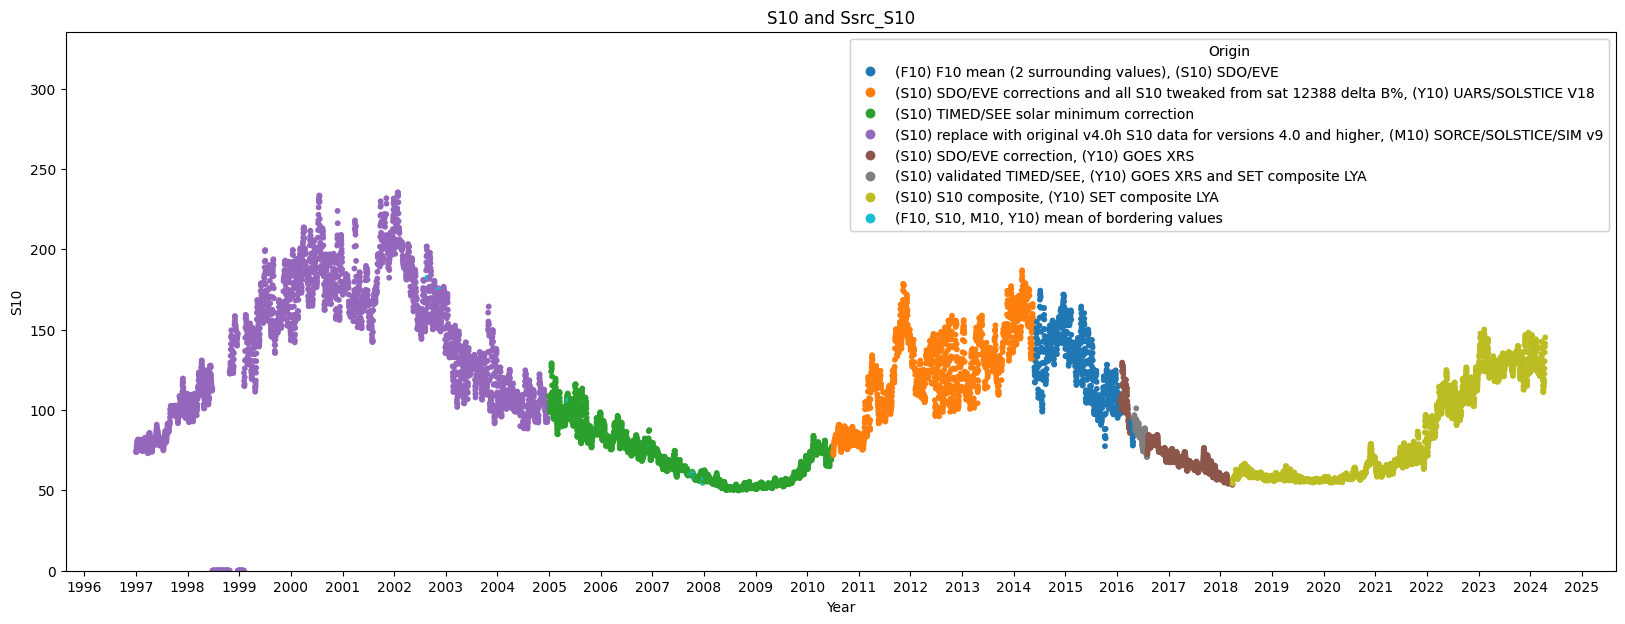

In [16]:
# hide

# Plot the variable S10. The color of the line will be determined by the value of Ssrc_S10
fig, ax = plt.subplots(figsize=(20, 7))
scatter = ax.scatter(df_raw.Date, df_raw.S10, c=df_raw.Ssrc_S10.cat.codes, cmap='tab10', s=10)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.set_xlabel('Year')
ax.set_ylabel('S10')
ax.set_title('S10 and Ssrc_S10')

# Legend configuration
ax.set_ylim(0,max(df_raw.S10)+100)
legend = ax.legend(handles=scatter.legend_elements()[0], labels=S10_legend, loc="best", title="Origin")
ax.add_artist(legend)

In [17]:
# Get the number of values equlas to zero in S10
print((df_raw.S10 == 0).sum())
# convert them to NA
df_raw.loc[df_raw.S10 == 0, 'S10'] = np.nan
print((df_raw.S10 == 0).sum())

165
0


tmp/pipes directory already exists.
Pipeline saved as tmp/pipes/preproc_pipe.pkl
Initial memory usage: 1.03 MB   
Final memory usage  : 517.43 KB  (-50.8%)
[Pipeline] .......... (step 1 of 3) Processing shrinker, total=   0.0s
[Pipeline] ... (step 2 of 3) Processing drop_duplicates, total=   0.0s
[Pipeline] ...... (step 3 of 3) Processing fill_missing, total=   0.2s


,Year,DDD,JulianDay,F10,F81c,S10,S81c,M10,M81c,Y10,Y81c,Ssrc,Ssrc_F10,Ssrc_S10,Ssrc_M10,Ssrc_Y10,Date
0,1997,1,2450450.0,72.400002,78.000000,74.000000,79.199997,65.400002,73.800003,61.900002,70.699997,1B11,1,B,1,1,1997-01-01 12:00:00
1,1997,2,2450451.0,72.099998,77.900002,73.800003,79.099998,66.900002,73.699997,63.400002,70.400002,1B11,1,B,1,1,1997-01-02 12:00:00
2,1997,3,2450452.0,73.300003,77.599998,75.000000,79.099998,70.099998,73.599998,64.900002,70.199997,1B11,1,B,1,1,1997-01-03 12:00:00
3,1997,4,2450453.0,73.800003,77.300003,76.300003,79.000000,71.599998,73.400002,65.500000,69.800003,1B11,1,B,1,1,1997-01-04 12:00:00
4,1997,5,2450454.0,74.400002,76.900002,77.599998,78.900002,72.400002,73.300003,66.699997,69.599998,1B11,1,B,1,1,1997-01-05 12:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9963,2024,103,2460413.0,152.300003,169.699997,130.300003,131.300003,154.199997,177.600006,168.899994,176.399994,1E11,1,E,1,1,2024-04-12 12:00:00
9964,2024,104,2460414.0,161.899994,170.199997,136.000000,131.399994,164.399994,178.000000,173.800003,176.500000,1E11,1,E,1,1,2024-04-13 12:00:00
9965,2024,105,2460415.0,179.500000,170.500000,139.399994,131.399994,184.199997,178.000000,180.699997,176.600006,1E11,1,E,1,1,2024-04-14 12:00:00
9966,2024,106,2460416.0,193.199997,170.699997,141.399994,131.399994,198.100006,178.000000,182.899994,176.699997,1E11,1,E,1,1,2024-04-15 12:00:00


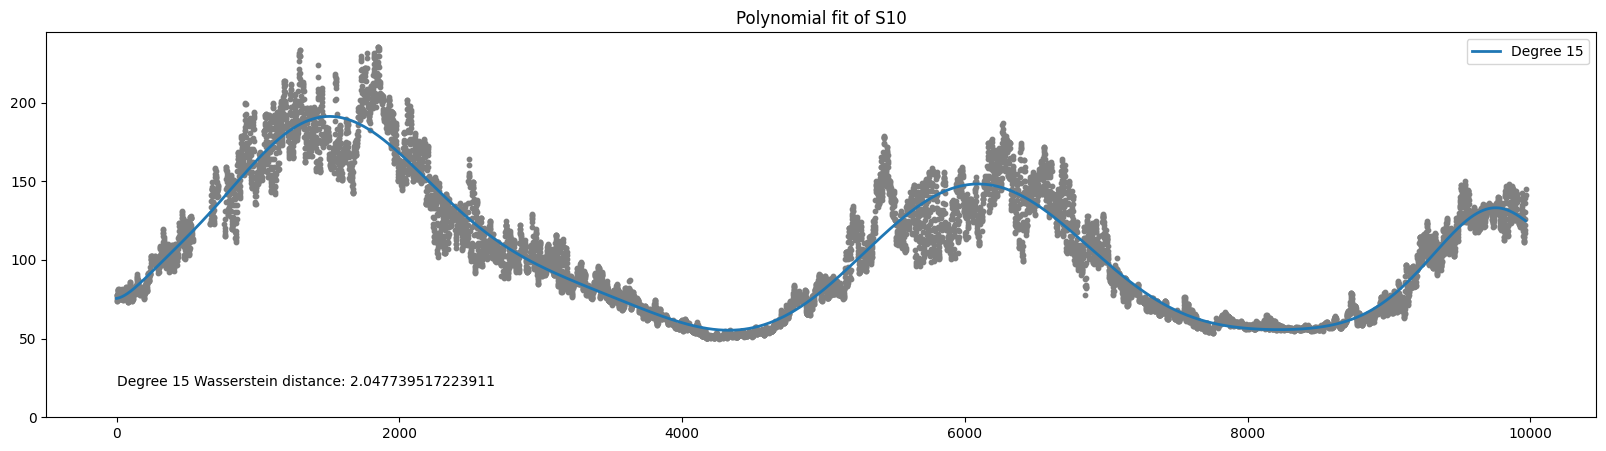

In [18]:
from swdf.preprocessing import PolyImputer
freq = '1D'
data_columns_fcst = config.data_columns_fcst
data_columns_time = ['Year', 'DDD']
data_columns = data_columns_fcst + data_columns_time if config.add_time_channels else data_columns_fcst

# sklearn's preprocessing pipeline
preproc_pipe = sklearn.pipeline.Pipeline([
    ('shrinker', TSShrinkDataFrame()), # shrik dataframe memory usage and set the right dtypes
    ('drop_duplicates', TSDropDuplicates(datetime_col='Date')), # drop duplicates
    ('fill_missing', PolyImputer(data_columns=data_columns, degrees=np.arange(2,16),plot=True)), # fill missing data (1st ffill. 2nd value=0)
], verbose=True)

save_object(preproc_pipe, "tmp/pipes/preproc_pipe.pkl")

df = preproc_pipe.fit_transform(df_raw)
df

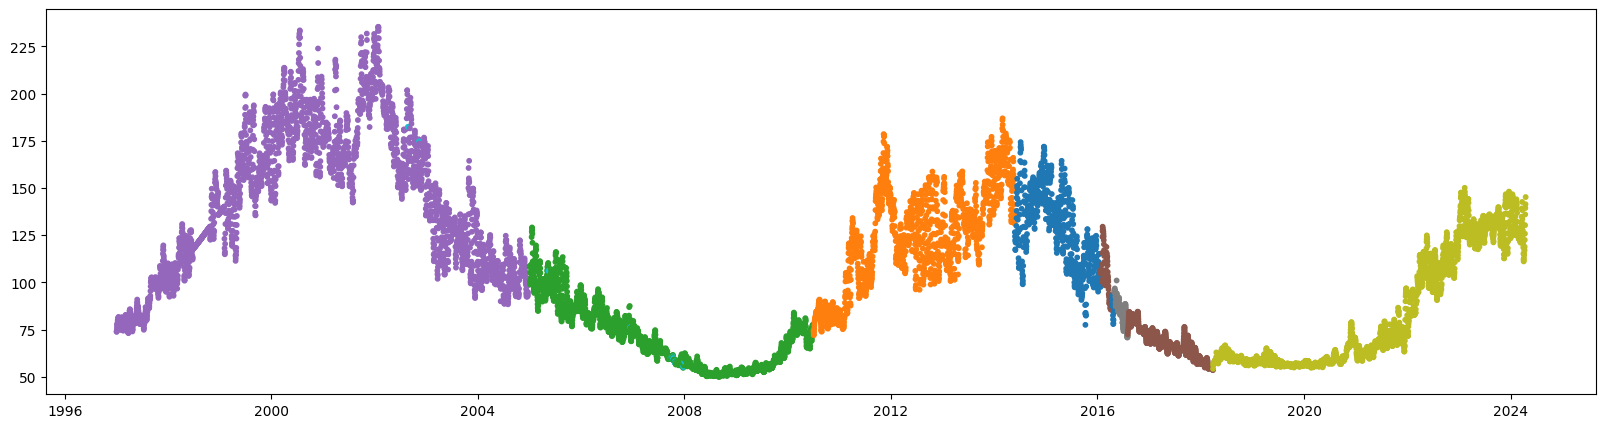

In [19]:
#hide
# plot the variable S10 again
fig, ax = plt.subplots(figsize=(20, 5))
ax.scatter(df.Date, df.S10, c=df.Ssrc_S10.cat.codes, cmap='tab10', s=10)

Save the dataframe as a file to retrieve it in other notebooks:

In [20]:
df.to_pickle('./preprocessed_data/dataframes/solfsmy.pkl')

In the paper by [Licata et al. (2020)]((https://agupubs.onlinelibrary.wiley.com/doi/pdf/10.1029/2020SW002496)), authors use a period from October 2012 through the end of 2018 for the benchmarking. Therefore, we will set the test set as the same period for our analysis, using the column Date as the timestamp, from October 2012 to the end of 2018. Everything before the test set will be used for training, and everything after the test set will be used for validation. In this paper, the authors also present some the thresholds for categorizing solar activity levels.

In [21]:
test_start_datetime = config.test_start_datetime
test_end_datetime = config.test_end_datetime

thresholds = {
    'F10': [(0,75), (76,150), (151,190), (191, np.inf)],
    'S10': [(0,65), (66,150), (151,215), (216, np.inf)],
    'M10': [(0,72), (73,144), (145,167), (168, np.inf)],
    'Y10': [(0,81), (82,148), (149,165), (166, np.inf)]
}

dict2yaml(thresholds, "distributions/thresholds.yaml")

In [22]:
test_period = (df_raw.Date >= test_start_datetime) & (df_raw.Date <= test_end_datetime)

df_cat = get_classified_columns(df_raw, thresholds)
df_cat = df_cat[~(test_period)]

historical_distribution = get_F10_historical_distribution(thresholds)

# Function parameter calculation
test_size = df[test_period].shape[0] / df.shape[0]
train_val_size = 1 - test_size
val_size = 0.15 / train_val_size
print(f"Test size: {test_size}, Validation size: {val_size}, Train size: {1 - test_size - 0.15}")

# Best segment size found: 250, val_size: 0.15, test_size: 0.65
best_comb, segments, distribution = find_closest_distribution(df_cat['F10_Cat'], historical_distribution, 250, val_size) 

Test size: 0.22903290529695025, Validation size: 0.19456083279115158, Train size: 0.6209670947030498
Total number of segments:30, Number of segments for validation: 5 (16.67%)


142506it [00:04, 29318.87it/s]

The closest group of segments to F10.7 categories has an euclidean distance of 0.005577472715903999


In [23]:
save_object(best_comb, "tmp/data/best_comb.pkl")
save_object(segments, "tmp/data/segments.pkl")

tmp/data directory already exists.
tuple saved as tmp/data/best_comb.pkl
tmp/data directory already exists.
list saved as tmp/data/segments.pkl


In [24]:
best_comb_idxs = [segments[i] for i in best_comb]
validation_segments = (df.index.isin(chain.from_iterable(best_comb_idxs)))

train_df = df[~validation_segments & ~test_period] 
train_distribution = get_classified_columns(train_df, thresholds)['F10_Cat'].value_counts(normalize=True).to_dict()

train_distribution

{'moderate': 0.5138173302107728,
 'low': 0.2908665105386417,
 'elevated': 0.12911787665886026,
 'high': 0.06619828259172522}

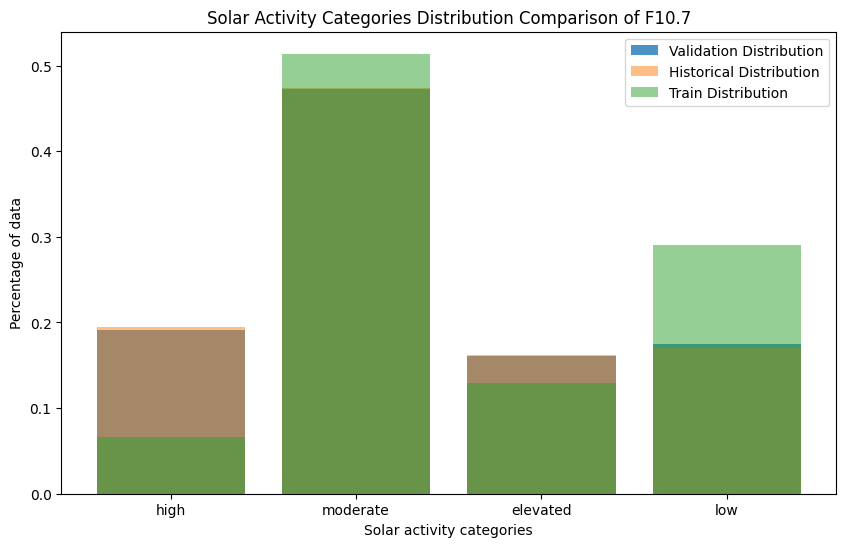

In [25]:
#|hide
# Plot of the distribution found
plt.figure(figsize=(10, 6))
plt.bar(distribution.keys(), distribution.values(), alpha=0.8, label='Validation Distribution')
plt.bar(historical_distribution.keys(), historical_distribution.values(), alpha=0.5, label='Historical Distribution')
plt.bar(train_distribution.keys(), train_distribution.values(), alpha=0.5, label='Train Distribution')

plt.xlabel('Solar activity categories')
plt.ylabel('Percentage of data')
plt.title('Solar Activity Categories Distribution Comparison of F10.7')
plt.legend()
plt.show()

In [26]:
validation = df.loc[chain.from_iterable(best_comb_idxs)]

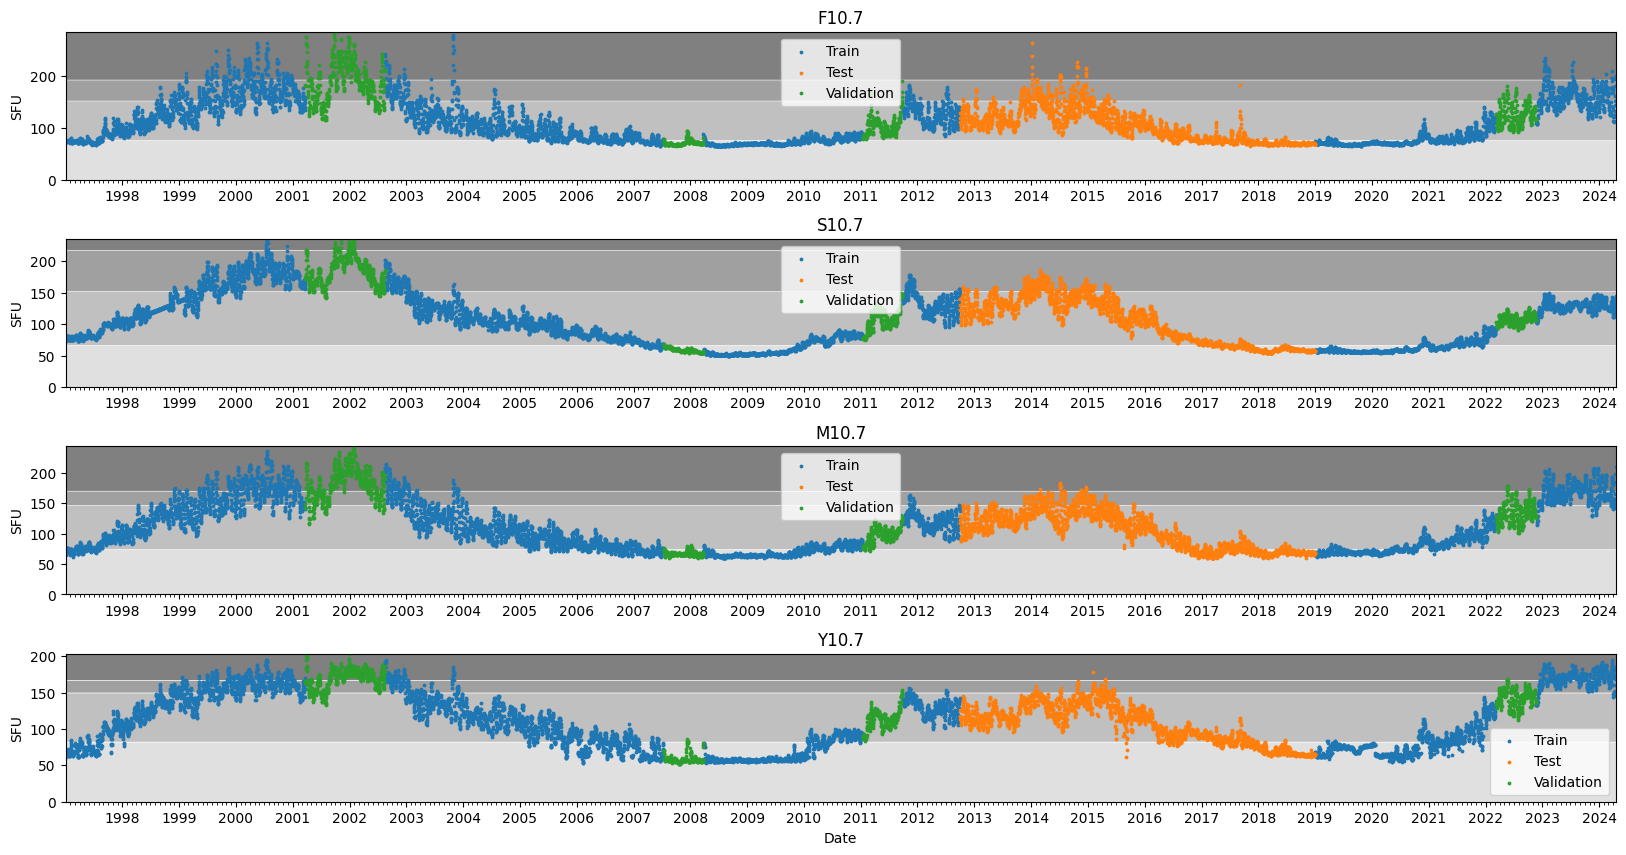

In [29]:
from matplotlib import patches as mpatches
fig, ax = plt.subplots(4, 1, figsize=(20, 10))
plt.subplots_adjust(hspace=0.4)

var_name = ['F10.7', 'S10.7', 'M10.7', 'Y10.7']

for i, var in enumerate(['F10', 'S10', 'M10', 'Y10']):
    ax[i].scatter(train_df.Date, train_df[var], label='Train', s=3)  # s parameter sets the size of the points
    ax[i].scatter(df.Date[(df.Date >= test_start_datetime) & (df.Date <= test_end_datetime)],
                  df[var][(df.Date >= test_start_datetime) & (df.Date <= test_end_datetime)],
                  label='Test', s=3)
    ax[i].scatter(validation.Date,
                  validation[var],
                  label='Validation', s=3)
    ax[i].set_title(var_name[i])
    ax[i].set_ylabel('SFU')  # Add y-axis label with SFU
    ax[i].legend()

    # Format x-axis to show only the years
    ax[i].xaxis.set_major_locator(mdates.YearLocator())
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax[i].xaxis.set_minor_locator(mdates.MonthLocator())  # optional, for minor ticks

    # Ensure all years are shown on the x-axis
    ax[i].set_xlim([df.Date.min(), df.Date.max()])

    set_ranges = np.zeros((int(df[var].max()), df.shape[0], 4))  # (Height, Width)

    for j, (start, end) in enumerate(thresholds[var]):
        if end == np.inf:
            end = 9999
        set_ranges[int(start):int(end), :, :] = [0, 0, 0, ((j + 1) / 4)]
   
    ax[i].imshow(set_ranges, extent=[df.Date.min(), df.Date.max(), 0, df[var].max()], aspect='auto', alpha=0.5, origin='lower')

# Optionally, you can set a common x-axis label for all subplots if desired
plt.xlabel('Date')
plt.show()

In [28]:
import more_itertools as mit

a = np.arange(0,len(segments))
train_comb = list(np.setdiff1d(a, best_comb))

X_val, y_val, split_val = sliding_window_generator(df, 0, data_columns=data_columns, config=config, comb=best_comb, segments=segments)
X_train, y_train, split_train = sliding_window_generator(df, split_val[-1]+1, data_columns=data_columns, config=config, comb=train_comb, segments=segments)
X_test, y_test, split_test = sliding_window_generator(df[test_period], split_train[-1]+1, data_columns=data_columns, config=config) 

X = np.concatenate([X_val, X_train, X_test])
y = np.concatenate([y_val, y_train, y_test])

splits = (split_train, split_val, split_test)
splits, X.shape, y.shape

(((#6240) [1125,1126,1127,1128,1129,1130,1131,1132,1133,1134...],
  (#1125) [0,1,2,3,4,5,6,7,8,9...],
  (#2242) [7365,7366,7367,7368,7369,7370,7371,7372,7373,7374...]),
 (9607, 4, 36),
 (9607, 4, 6))

In [29]:
# Now that we have defined the splits for this particular experiment, we'll scale
# the data
exp_pipe = sklearn.pipeline.Pipeline([
    ('scaler', TSStandardScaler(columns=data_columns)),
], verbose=True)

df_scaled = exp_pipe.fit_transform(df.copy())

save_object(exp_pipe, 'tmp/pipes/exp_pipe.pkl')
df.head()

[Pipeline] ............ (step 1 of 1) Processing scaler, total=   0.0s
tmp/pipes directory already exists.
Pipeline saved as tmp/pipes/exp_pipe.pkl


,Year,DDD,JulianDay,F10,F81c,S10,S81c,M10,M81c,Y10,Y81c,Ssrc,Ssrc_F10,Ssrc_S10,Ssrc_M10,Ssrc_Y10,Date
0,1997,1,2450450.0,72.400002,78.000000,74.000000,79.199997,65.400002,73.800003,61.900002,70.699997,1B11,1,B,1,1,1997-01-01 12:00:00
1,1997,2,2450451.0,72.099998,77.900002,73.800003,79.099998,66.900002,73.699997,63.400002,70.400002,1B11,1,B,1,1,1997-01-02 12:00:00
2,1997,3,2450452.0,73.300003,77.599998,75.000000,79.099998,70.099998,73.599998,64.900002,70.199997,1B11,1,B,1,1,1997-01-03 12:00:00
3,1997,4,2450453.0,73.800003,77.300003,76.300003,79.000000,71.599998,73.400002,65.500000,69.800003,1B11,1,B,1,1,1997-01-04 12:00:00
4,1997,5,2450454.0,74.400002,76.900002,77.599998,78.900002,72.400002,73.300003,66.699997,69.599998,1B11,1,B,1,1,1997-01-05 12:00:00


 ### Apply a sliding window. 

### Train

In [30]:
ranges = np.array(list(thresholds.values()))

weights = {k: np.abs(train_distribution.get(k, 0) - historical_distribution.get(k, 0)) for k in set(train_distribution) | set(historical_distribution)}
factor = 1.0/sum(weights.values())
weights = {k: v*factor for k, v in weights.items()}

solact_levels = ['low', 'moderate', 'elevated', 'high'] 
solact_distribution = [weights[k] for k in solact_levels]
solact_distribution, weights

([0.3822183061365774,
  0.11778169386342262,
  0.09973265376001136,
  0.4002673462399885],
 {'high': 0.4002673462399885,
  'elevated': 0.09973265376001136,
  'moderate': 0.11778169386342262,
  'low': 0.3822183061365774})

In [31]:
save_object(ranges, "tmp/loss_param/ranges.pkl")
save_object(solact_distribution, "tmp/loss_param/solact_distribution.pkl")

tmp/loss_param directory already exists.
ndarray saved as tmp/loss_param/ranges.pkl
tmp/loss_param directory already exists.
list saved as tmp/loss_param/solact_distribution.pkl


epoch,train_loss,valid_loss,loss_low,loss_moderate,loss_elevated,loss_high,time
0,23.401255,34.657547,1.028567,5.287171,3.508423,24.833376,00:00
1,20.506594,29.066236,0.892825,5.346565,2.811993,20.014851,00:00
2,22.247658,38.404026,0.814026,6.085057,3.878712,27.626240,00:00
3,21.421762,47.900551,1.262708,9.438241,6.151262,31.048336,00:00
4,23.727537,88.929108,2.641568,14.663178,11.656274,59.968082,00:00
5,22.793747,61.136772,1.483029,13.745847,7.022169,38.885731,00:00
6,22.482666,76.806549,1.340083,9.800249,7.554061,58.112144,00:00
7,23.490904,141.210693,4.366117,34.228348,15.562800,87.053452,00:00
8,24.508434,84.615715,3.426023,18.839428,12.329885,50.020397,00:00
9,25.186436,75.975441,3.968617,18.809446,8.212068,44.985321,00:00


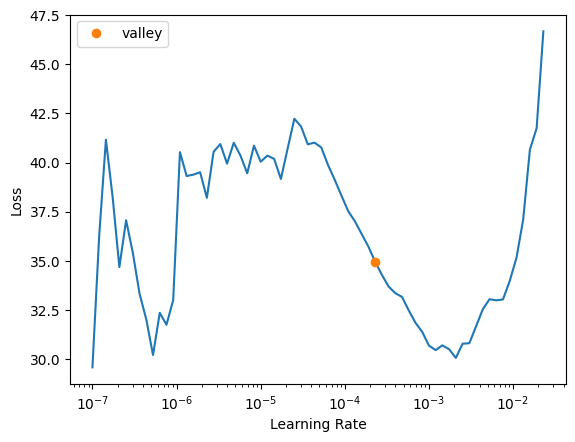

In [33]:
from swdf.losses import *

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
loss = wMSELoss(ranges, solact_distribution).to(device)
metrics = LossMetrics(loss, solact_levels).get_metrics()

wandb_callback = WandbCallback(log_preds=False)
cbs = L(wandb_callback) if config.wandb.enabled else L()
learn = TSForecaster(X, y, splits=splits, batch_size=config.bs,
                     pipelines=[preproc_pipe, exp_pipe], 
                     arch=config.arch_name, 
                     metrics=metrics,
                     loss_func=loss,
                     arch_config=dict(config.arch), 
                     init=config.init_weights,
                     cbs= cbs + ShowGraphCallback(), 
                     partial_n=config.partial_n)
lr_max = learn.lr_find().valley if config.lr_max is None else config.lr_max

learn.fit_one_cycle(n_epoch=config.n_epoch, lr_max=config.lr_max)


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

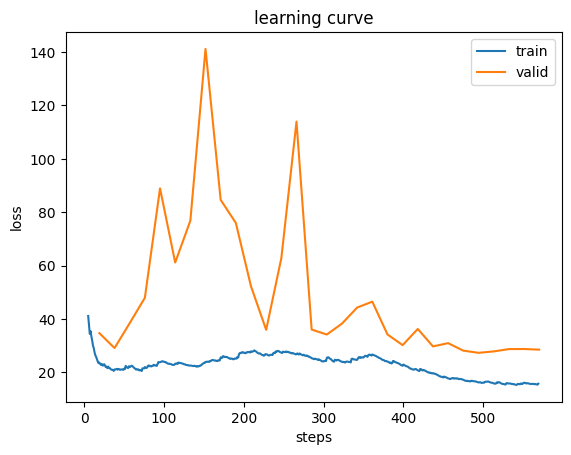

In [34]:
learn.recorder.plot_loss()

In [35]:
# Print the validation loss and save it in case other notebooks (optuna) wants to
# use it for hyperparameter optimization
valid_loss = learn.validate()[0]

print(valid_loss)
%store valid_loss

28.471721649169922
Stored 'valid_loss' (float)


In [36]:
best_valid_loss = np.inf
%store -r best_valid_loss

save_all_or_best = (config.is_optuna_study and valid_loss < best_valid_loss) or not config.is_optuna_study

if save_all_or_best:
    best_valid_loss = valid_loss
    %store best_valid_loss                                             

    # Save locally and in wandb if online and enabled
    learn.save_all(path='tmp', verbose=True) 
    if run is not None and config.wandb_mode and config.wandb_log_learner:
        # Save the learner (all tmp/dls, tmp/model.pth, and tmp/learner.pkl). 
        run.log_artifact('tmp', type='learner', name='solfsmy')
    
    # Save the best model
    model = {}
    model['models'] = [learn.model]
    model['lookback'] = config.lookback
    model['horizon'] = config.horizon
    model['data_columns'] = data_columns
    model['thresholds'] = thresholds

    torch.save(model, 'models/best_model.pth')

Stored 'best_valid_loss' (float)
Learner saved:
path          = 'tmp'
dls_fname     = '['dls_0.pth', 'dls_1.pth', 'dls_2.pth']'
model_fname   = 'model.pth'
learner_fname = 'learner.pkl'


In [37]:
# Save everything
learn.dls.loaders += [learn.dls.valid.new_dl(X[splits[2]], y[splits[2]])] # Add test datalaoder
# Remove the wandb callback to avoid errors when downloading the learner
if config.wandb.enabled:
    learn.remove_cb(wandb_callback)

In [38]:
# Log the test loss to wandb
test_loss = learn.validate(ds_idx=2)[0]
print(test_loss)
if run is not None:
    run.log(dict(test_loss=test_loss))

10.378812789916992


In [39]:
if run is not None:
    run.finish()